In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from sklearn.model_selection import train_test_split

from seiz_eeg.dataset import EEGDataset

# The data

We model *segments* of brain activity, which correspond to windows of a longer *session* of EEG recording.

These segments, and their labels, are described in the `segments.parquet` files, which can be directly loaded with `pandas`.

In [ ]:
# You might need to change this according to where you store the data folder
# Inside your data folder, you should have the following structure:
# data
# ├── train
# │   ├── signals/
# │   ├── segments.parquet
# │-- test
#     ├── signals/
#     ├── segments.parquet

data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

# Split the dataset by the 'patient' column
patients = clips_tr['signals_path'].unique()
train_patients, val_patients = train_test_split(patients, test_size=0.2, random_state=42)

# Create training and validation datasets
train_clips = clips_tr[clips_tr['signals_path'].isin(train_patients)]
val_clips = clips_tr[clips_tr['signals_path'].isin(val_patients)]

## Loading the signals

For convenience, the `EEGDataset class` provides functionality for loading each segment and its label as `numpy` arrays.

You can provide an optional `signal_transform` function to preprocess the signals. In the example below, we have two bandpass filtering functions, which extract frequencies between 0.5Hz and 30Hz which are used in seizure analysis literature:

The `EEGDataset` class also allows to load all data in memory, instead of reading it from disk at every iteration. If your compute allows it, you can use `prefetch=True`.

In [3]:
bp_filter = signal.butter(4, (0.5, 30), btype="bandpass", output="sos", fs=250)


def time_filtering(x: np.ndarray) -> np.ndarray:
    """Filter signal in the time domain"""
    return signal.sosfiltfilt(bp_filter, x, axis=0).copy()


def fft_filtering(x: np.ndarray) -> np.ndarray:
    """Compute FFT and only keep"""
    x = np.abs(np.fft.fft(x, axis=0))
    x = np.log(np.where(x > 1e-8, x, 1e-8))

    win_len = x.shape[0]
    # Only frequencies b/w 0.5 and 30Hz
    return x[int(0.5 * win_len // 250) : 30 * win_len // 250]

## Compatibility with PyTorch

The `EEGDataset` class is compatible with [pytorch datasets and dataloaders](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html), which allow you to load batched data.

In [4]:
# Dependences
import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from tqdm import tqdm

In [5]:
def seed_everything(seed: int):
    # Python random module
    random.seed(seed)
    # Numpy random module
    np.random.seed(seed)
    # Torch random seeds
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.

    # Set PYTHONHASHSEED environment variable for hash-based operations
    os.environ["PYTHONHASHSEED"] = str(seed)

    # Ensure deterministic behavior in cudnn (may slow down your training)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1)

In [6]:
train_dataset = EEGDataset(
        train_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

val_dataset = EEGDataset(
        val_clips,
        signals_root=DATA_ROOT / "train",
        signal_transform=fft_filtering,
        prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
    )

loader_tr = DataLoader(
        dataset=train_dataset,
        shuffle=True,
        batch_size=512,
    )

loader_val = DataLoader(
        dataset=val_dataset,
        shuffle=True,
        batch_size=512,
    )

In [7]:
# Set up device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [19]:
adj = np.genfromtxt('./data/distances_3d.csv', skip_header=1, delimiter=',')[:, -1].reshape(19,19)
adj = torch.tensor(adj, dtype=torch.float32).to(device).unsqueeze(0)
print(adj.shape)

torch.Size([1, 19, 19])


## Spatial Temporal Graph Convolution Network

In this section, we train a bidirectional lstm model with an mlp for the sequence classification.

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, residual=False, dropout=0.3):
        super(STGCNBlock, self).__init__()
        self.A = A
        self.K = A.size(0)

        self.graph_conv = nn.Conv2d(in_channels, out_channels * self.K, kernel_size=1)

        self.temporal_conv = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(5, 1), stride=(stride, 1), padding=(2, 0)),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout),  # 🆕 Dropout added here
        )

        if not residual:
            self.residual = lambda x: 0
        elif in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU()

    def forward(self, x):
        res = x
        N, C, T, V = x.size()
        x_gc = self.graph_conv(x)
        x_gc = x_gc.view(N, self.K, -1, T, V)
        x = torch.einsum('nkctv,kvw->nctw', x_gc, self.A)
        x = self.temporal_conv(x) + self.residual(res)
        return self.relu(x)


class STGCN(nn.Module):
    def __init__(self, in_channels, num_classes, A, edge_importance_weighting=True, dropout=0.3):
        super(STGCN, self).__init__()
        self.A = A
        self.edge_importance = nn.Parameter(torch.ones(A.shape)) if edge_importance_weighting else 1

        self.stgcn_blocks = nn.ModuleList([
            STGCNBlock(in_channels, 32, A, dropout=dropout),
            STGCNBlock(32, 32, A, dropout=dropout),
            STGCNBlock(32, 64, A, stride=2, dropout=dropout),
            STGCNBlock(64, 64, A, dropout=dropout),
            STGCNBlock(64, 128, A, stride=2, dropout=dropout),
        ])

        self.fc = nn.Sequential(
            nn.Dropout(dropout),         # 🆕 Optional: dropout before final linear
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1) if x.dim() == 3 else x  # (N, C, T, V)
        A = self.A * self.edge_importance
        for block in self.stgcn_blocks:
            x = block(x)
        x = F.avg_pool2d(x, x.size()[2:])  # Global avg pooling
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [20]:
model = STGCN(num_classes=1, in_channels=1, A=adj).to(device)
class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [21]:
num_params = sum(p.numel() for p in model.parameters())
print(f"Number of model parameters: {num_params}")

Number of model parameters: 150922


In [22]:
from sklearn.metrics import f1_score, precision_score, recall_score

# Training loop
num_epochs = 10
train_losses = []
val_losses = []
val_f1_scores = []
val_precision_scores = []
val_recall_scores = []
val_best_thresholds = []

for epoch in tqdm(range(num_epochs), desc="Training"):
    model.train()
    running_loss = 0.0

    for x_batch, y_batch in loader_tr:
        # Move data to GPU (if available)
        x_batch = x_batch.float().to(device)  # [batch_size, seq_len, input_dim]
        y_batch = y_batch.float().unsqueeze(1).to(device)  # [batch_size, 1]

        # Forward pass
        logits = model(x_batch)
        loss = criterion(logits, y_batch)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(loader_tr)
    train_losses.append(avg_loss)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for x_val, y_val in loader_val:
            # Move data to GPU (if available)
            x_val = x_val.float().to(device)  # [batch_size, seq_len, input_dim]
            y_val = y_val.float().unsqueeze(1).to(device)  # [batch_size, 1]

            # Forward pass
            val_logits = model(x_val)
            val_probs = torch.sigmoid(val_logits)  # Apply sigmoid for binary classification
            val_preds = (val_probs > 0.5).int()  # Convert probabilities to binary predictions

            # Collect all labels and predictions
            all_labels.extend(y_val.cpu().numpy())
            all_preds.extend(val_preds.cpu().numpy())

            # Compute validation loss
            val_loss = criterion(val_logits, y_val)
            val_running_loss += val_loss.item()

    avg_val_loss = val_running_loss / len(loader_val)
    val_losses.append(avg_val_loss)

    # Compute metrics for validation data
    all_labels = np.array(all_labels).flatten()
    all_preds = np.array(all_preds).flatten()
    val_f1 = f1_score(all_labels, all_preds, average='macro')
    val_precision = precision_score(all_labels, all_preds, average='macro')
    val_recall = recall_score(all_labels, all_preds, average='macro')
    val_f1_scores.append(val_f1)
    val_precision_scores.append(val_precision)
    val_recall_scores.append(val_recall)
    print(val_f1)

Training:  10%|██████▏                                                       | 1/10 [00:12<01:53, 12.63s/it]

0.677047154330132


Training:  20%|████████████▍                                                 | 2/10 [00:24<01:39, 12.45s/it]

0.6974249809861465


Training:  30%|██████████████████▌                                           | 3/10 [00:37<01:27, 12.47s/it]

0.7288604739766011


Training:  40%|████████████████████████▊                                     | 4/10 [00:49<01:14, 12.45s/it]

0.7307021008588815


Training:  50%|███████████████████████████████                               | 5/10 [01:02<01:02, 12.44s/it]

0.7129742022106729


Training:  60%|█████████████████████████████████████▏                        | 6/10 [01:14<00:49, 12.48s/it]

0.6993133318379383


Training:  70%|███████████████████████████████████████████▍                  | 7/10 [01:26<00:37, 12.36s/it]

0.7008793356130922


Training:  80%|█████████████████████████████████████████████████▌            | 8/10 [01:39<00:24, 12.45s/it]

0.763235796071617


Training:  90%|███████████████████████████████████████████████████████▊      | 9/10 [01:51<00:12, 12.35s/it]

0.7043956571740397


Training: 100%|█████████████████████████████████████████████████████████████| 10/10 [02:04<00:00, 12.42s/it]

0.6908826648478734


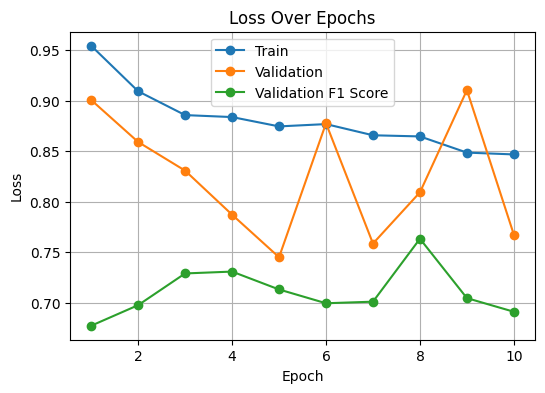

In [23]:
# Plot the training loss
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_losses, marker="o")
plt.plot(range(1, num_epochs + 1), val_f1_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_precision_scores, marker="o")
#plt.plot(range(1, num_epochs + 1), val_recall_scores, marker="o")
plt.title("Loss Over Epochs")
plt.legend(["Train", "Validation", "Validation F1 Score", "Validation Precision", "Validation Recall"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
from evaluation import evaluate

data_path = "./data"

DATA_ROOT = Path(data_path)
clips_tr = pd.read_parquet(DATA_ROOT / "train/segments.parquet")

class_weight = 4
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.FloatTensor([class_weight]).to(device))

evaluate(
    STGCN,
    clips_tr,
    signals_root=DATA_ROOT / "train",
    num_epochs=5,
    learning_rate=1e-3,
    model_args={
        "num_classes": 1,
        "in_channels": 1,
        "A": adj,
    },
    criterion=criterion,
    signal_transform=fft_filtering,
    batch_size=512,
    prefetch=True,  # If your compute does not allow it, you can use `prefetch=False`
)

Fold 1/5
Fold 1 F1 Score: 0.6951
Fold 2/5
Fold 2 F1 Score: 0.6570
Fold 3/5
Fold 3 F1 Score: 0.6596
Fold 4/5
Fold 4 F1 Score: 0.6140
Fold 5/5
Fold 5 F1 Score: 0.6743
Cross-Validation Average F1 Score: 0.6600
Cross-Validation F1 Score Standard Deviation: 0.0267


(np.float64(0.660012087696017), np.float64(0.026698707178870643))

: 